In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

In [26]:
data_csv = pd.read_csv('../data/lstm.csv', usecols=[1])
# data_csv = pd.read_csv('../data/lstm2.csv', usecols=[5])

data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [27]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)
train_size = int(len(data_X) * 0.9)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [28]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(Model, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.reg = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 1. Run LSTM forward with "x"
        x, (hn, cn) = self.lstm(x)
        # 2. Reshape LSTM output as (sequence*batch, hidden)
        # 2.1 get the shape (s, b, h) of x
        s, b, h = x.shape
        # 2.2 reshape x into (s*b, h) using view(.)
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [29]:
look_back = 2
hidden_size = 4

model = Model(look_back, hidden_size)
lossfn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


Epoch: 100, Loss: 0.00803
Epoch: 200, Loss: 0.00679
Epoch: 300, Loss: 0.00473
Epoch: 400, Loss: 0.00247
Epoch: 500, Loss: 0.00152
Epoch: 600, Loss: 0.00099
Epoch: 700, Loss: 0.00084
Epoch: 800, Loss: 0.00071
Epoch: 900, Loss: 0.00057
Epoch: 1000, Loss: 0.00050


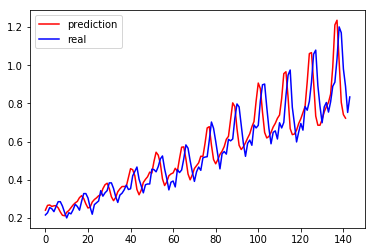

In [30]:
for e in range(1000):
    out = model(train_x)
    loss = lossfn(out, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

model = model.eval()

data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
pred_test = model(data_X)

pred_test = pred_test.view(-1).data.numpy()

plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')
plt.show()